Loaded ECG signal with 42017 samples (168.1 seconds)


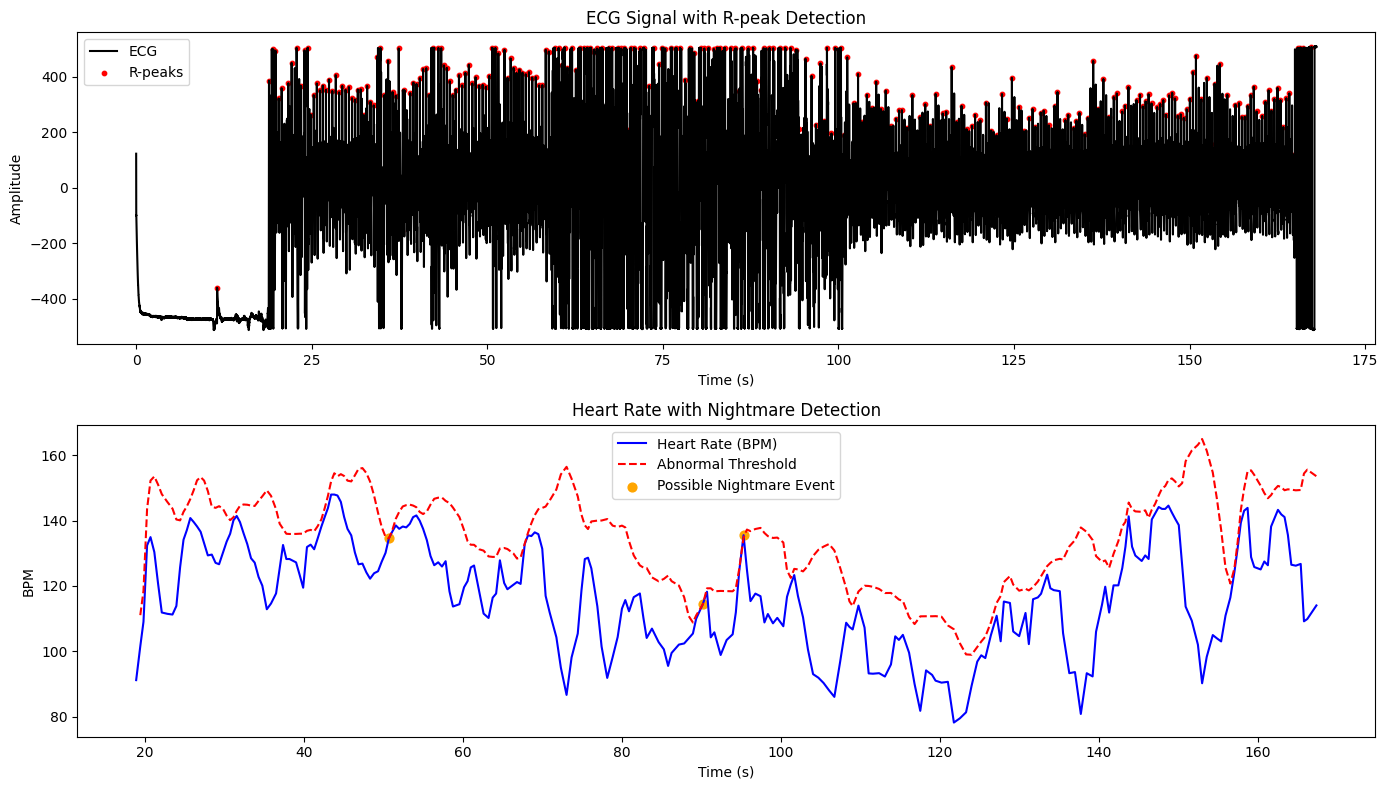

⚠️ Possible nightmare events detected at:
 - 50.70 seconds
 - 90.18 seconds
 - 95.31 seconds


In [1]:
"""
Nightmare Detection from ECG
----------------------------
This program analyzes ECG data recorded at 250 Hz
to detect abnormal BPM spikes that may correspond to
nightmare or stress episodes during sleep.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ==========================================================
# 1️⃣ Load ECG Data
# ==========================================================
fs = 250  # Sampling frequency (Hz)
df = pd.read_csv("finalTestData.csv")
ecg = df.iloc[:, 0].to_numpy()
time = np.arange(len(ecg)) / fs

print(f"Loaded ECG signal with {len(ecg)} samples ({len(ecg)/fs:.1f} seconds)")

# ==========================================================
# 2️⃣ Detect R-peaks in the ECG
# ==========================================================
# Distance=fs*0.4 means minimum 0.4s (150 BPM max) between peaks
peaks, _ = find_peaks(ecg, distance=fs*0.4, prominence=np.std(ecg)*0.5)

# ==========================================================
# 3️⃣ Compute Heart Rate (BPM)
# ==========================================================
rr_intervals = np.diff(peaks) / fs  # seconds between heartbeats
bpm = 60 / rr_intervals             # beats per minute
time_bpm = peaks[1:] / fs           # time corresponding to each BPM value

# Smooth BPM curve with small rolling window
bpm_smooth = pd.Series(bpm).rolling(window=5, center=True, min_periods=1).mean()

# ==========================================================
# 4️⃣ Detect Abnormal Spikes (Potential Nightmares)
# ==========================================================
# Rolling window across BPM values (not samples)
window_size = 10
bpm_series = pd.Series(bpm_smooth)
rolling_mean = bpm_series.rolling(window=window_size, min_periods=1).mean()
rolling_std = bpm_series.rolling(window=window_size, min_periods=1).std()
threshold = rolling_mean + 2 * rolling_std   # spike if above mean + 2*std

# Boolean mask for spikes
abnormal_mask = bpm_series > threshold
nightmare_times = time_bpm[abnormal_mask.to_numpy()]

# ==========================================================
# 5️⃣ Plot Results
# ==========================================================
plt.figure(figsize=(14, 8))

# ECG Signal
plt.subplot(2, 1, 1)
plt.plot(time, ecg, label="ECG", color="black")
plt.scatter(peaks / fs, ecg[peaks], color="red", s=10, label="R-peaks")
plt.title("ECG Signal with R-peak Detection")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# BPM Curve
plt.subplot(2, 1, 2)
plt.plot(time_bpm, bpm_smooth, label="Heart Rate (BPM)", color="blue")
plt.plot(time_bpm, threshold, label="Abnormal Threshold", color="red", linestyle="--")
plt.scatter(time_bpm[abnormal_mask], bpm_smooth[abnormal_mask], color="orange", s=40,
            label="Possible Nightmare Event")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.title("Heart Rate with Nightmare Detection")
plt.legend()
plt.tight_layout()
plt.show()

# ==========================================================
# 6️⃣ Print Results
# ==========================================================
if len(nightmare_times) > 0:
    print("⚠️ Possible nightmare events detected at:")
    for t in nightmare_times:
        print(f" - {t:.2f} seconds")
else:
    print("✅ No significant BPM spikes detected — no nightmares found.")


In [2]:
"""
Advanced Nightmare Detection from ECG via HRV Analysis
------------------------------------------------------
This program:
1. Loads ECG data at 250 Hz
2. Detects R-peaks using signal prominence
3. Computes heart rate and HRV (SDNN, RMSSD)
4. Analyzes HRV frequency spectrum (LF/HF ratio)
5. Detects abnormal HRV patterns indicating stress or nightmares
6. Plots ECG, HRV metrics, and detected events
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch

# ==========================================================
# 1️⃣ Load ECG data
# ==========================================================
fs = 250  # sampling frequency (Hz)
df = pd.read_csv("finalTestData.csv")
ecg = df.iloc[:, 0].to_numpy()
time = np.arange(len(ecg)) / fs

print(f"Loaded ECG with {len(ecg)} samples ({len(ecg)/fs:.1f} s duration)")

# ==========================================================
# 2️⃣ Detect R-peaks
# ==========================================================
peaks, _ = find_peaks(ecg, distance=fs*0.4, prominence=np.std(ecg)*0.5)
rr_intervals = np.diff(peaks) / fs  # in seconds
time_rr = peaks[1:] / fs

# ==========================================================
# 3️⃣ Compute HR and basic HRV metrics
# ==========================================================
bpm = 60 / rr_intervals
bpm_smooth = pd.Series(bpm).rolling(window=5, center=True, min_periods=1).mean()

mean_rr = np.mean(rr_intervals)
sdnn = np.std(rr_intervals)
rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

print("\n---- HRV Metrics ----")
print(f"Mean RR Interval: {mean_rr:.3f} s")
print(f"SDNN (std dev of RR): {sdnn:.3f} s")
print(f"RMSSD: {rmssd:.3f} s")

# ==========================================================
# 4️⃣ Frequency-domain HRV (LF/HF ratio)
# ==========================================================
# Interpolate RR intervals to even sampling for spectral analysis
fs_hrv = 4  # 4 Hz interpolation rate typical for HRV
time_interp = np.arange(time_rr[0], time_rr[-1], 1/fs_hrv)
rr_interp = np.interp(time_interp, time_rr, rr_intervals - np.mean(rr_intervals))

# Welch PSD to find LF and HF components
f, pxx = welch(rr_interp, fs=fs_hrv, nperseg=256)
lf_band = (0.04, 0.15)
hf_band = (0.15, 0.4)

lf_power = np.trapz(pxx[(f >= lf_band[0]) & (f < lf_band[1])],
                    f[(f >= lf_band[0]) & (f < lf_band[1])])
hf_power = np.trapz(pxx[(f >= hf_band[0]) & (f < hf_band[1])],
                    f[(f >= hf_band[0]) & (f < hf_band[1])])

lf_hf_ratio = lf_power / hf_power if hf_power > 0 else np.inf

print(f"LF Power: {lf_power:.5f}, HF Power: {hf_power:.5f}, LF/HF Ratio: {lf_hf_ratio:.2f}")

# ==========================================================
# 5️⃣ Detect abnormal HRV changes (possible nightmares)
# ==========================================================
# z-score of RR intervals for sudden irregularities
z_scores = (rr_intervals - np.mean(rr_intervals)) / np.std(rr_intervals)
abnormal_mask = np.abs(z_scores) > 2.0
nightmare_times = time_rr[abnormal_mask]

# ==========================================================
# 6️⃣ Plot ECG, BPM, HRV, and PSD
# ==========================================================
plt.figure(figsize=(14, 10))

# ECG with detected R-peaks
plt.subplot(3, 1, 1)
plt.plot(time, ecg, color='black', linewidth=0.8)
plt.scatter(peaks / fs, ecg[peaks], color='red', s=12, label="R-peaks")
plt.title("ECG Signal with Detected R-peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# BPM with abnormal detections
plt.subplot(3, 1, 2)
plt.plot(time_rr, bpm_smooth, label="Heart Rate (BPM)", color='blue')
plt.scatter(time_rr[abnormal_mask], bpm_smooth[abnormal_mask],


SyntaxError: incomplete input (2209371101.py, line 97)

Loaded ECG with 42017 samples (168.1 s duration)

---- HRV Metrics ----
Mean RR Interval: 0.559 s
SDNN (std dev of RR): 0.432 s
RMSSD: 0.441 s
LF Power: 0.00130, HF Power: 0.00513, LF/HF Ratio: 0.25


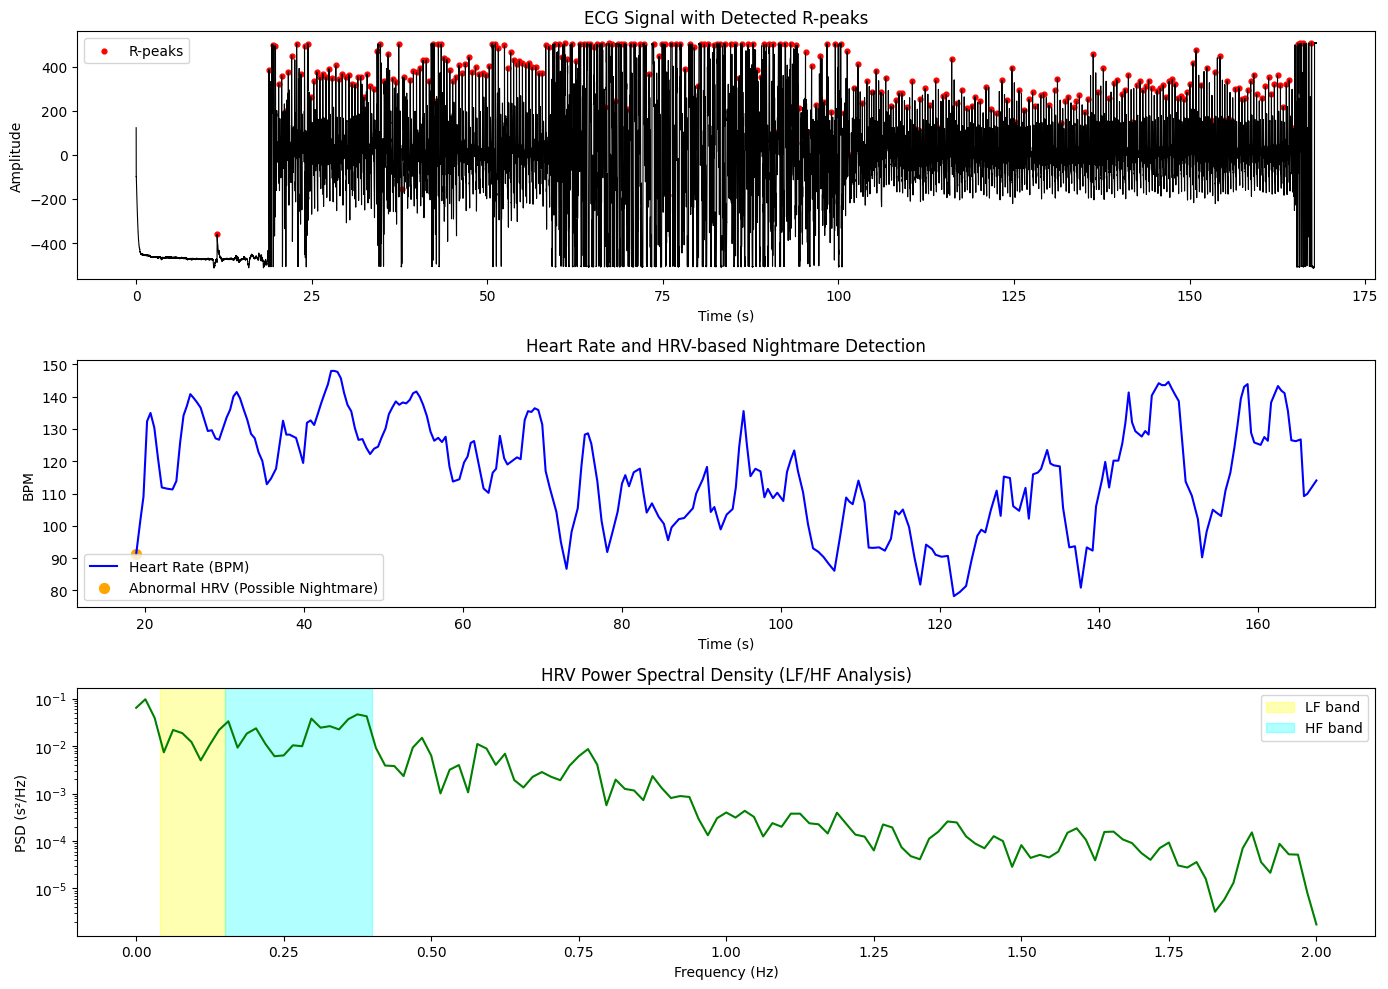


⚠️ Possible nightmare events detected around:
 - 18.92 seconds


In [3]:
"""
Advanced Nightmare Detection from ECG via HRV Analysis
------------------------------------------------------
This program:
1. Loads ECG data at 250 Hz
2. Detects R-peaks using signal prominence
3. Computes heart rate and HRV (SDNN, RMSSD)
4. Analyzes HRV frequency spectrum (LF/HF ratio)
5. Detects abnormal HRV patterns indicating stress or nightmares
6. Plots ECG, HRV metrics, and detected events
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch

# ==========================================================
# 1️⃣ Load ECG data
# ==========================================================
fs = 250  # sampling frequency (Hz)
df = pd.read_csv("finalTestData.csv")
ecg = df.iloc[:, 0].to_numpy()
time = np.arange(len(ecg)) / fs

print(f"Loaded ECG with {len(ecg)} samples ({len(ecg)/fs:.1f} s duration)")

# ==========================================================
# 2️⃣ Detect R-peaks
# ==========================================================
peaks, _ = find_peaks(ecg, distance=fs*0.4, prominence=np.std(ecg)*0.5)
rr_intervals = np.diff(peaks) / fs  # in seconds
time_rr = peaks[1:] / fs

# ==========================================================
# 3️⃣ Compute HR and basic HRV metrics
# ==========================================================
bpm = 60 / rr_intervals
bpm_smooth = pd.Series(bpm).rolling(window=5, center=True, min_periods=1).mean()

mean_rr = np.mean(rr_intervals)
sdnn = np.std(rr_intervals)
rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

print("\n---- HRV Metrics ----")
print(f"Mean RR Interval: {mean_rr:.3f} s")
print(f"SDNN (std dev of RR): {sdnn:.3f} s")
print(f"RMSSD: {rmssd:.3f} s")

# ==========================================================
# 4️⃣ Frequency-domain HRV (LF/HF ratio)
# ==========================================================
# Interpolate RR intervals to even sampling for spectral analysis
fs_hrv = 4  # 4 Hz interpolation rate typical for HRV
time_interp = np.arange(time_rr[0], time_rr[-1], 1/fs_hrv)
rr_interp = np.interp(time_interp, time_rr, rr_intervals - np.mean(rr_intervals))

# Welch PSD to find LF and HF components
f, pxx = welch(rr_interp, fs=fs_hrv, nperseg=256)
lf_band = (0.04, 0.15)
hf_band = (0.15, 0.4)

lf_power = np.trapz(pxx[(f >= lf_band[0]) & (f < lf_band[1])],
                    f[(f >= lf_band[0]) & (f < lf_band[1])])
hf_power = np.trapz(pxx[(f >= hf_band[0]) & (f < hf_band[1])],
                    f[(f >= hf_band[0]) & (f < hf_band[1])])

lf_hf_ratio = lf_power / hf_power if hf_power > 0 else np.inf

print(f"LF Power: {lf_power:.5f}, HF Power: {hf_power:.5f}, LF/HF Ratio: {lf_hf_ratio:.2f}")

# ==========================================================
# 5️⃣ Detect abnormal HRV changes (possible nightmares)
# ==========================================================
# z-score of RR intervals for sudden irregularities
z_scores = (rr_intervals - np.mean(rr_intervals)) / np.std(rr_intervals)
abnormal_mask = np.abs(z_scores) > 2.0
nightmare_times = time_rr[abnormal_mask]

# ==========================================================
# 6️⃣ Plot ECG, BPM, HRV, and PSD
# ==========================================================
plt.figure(figsize=(14, 10))

# ECG with detected R-peaks
plt.subplot(3, 1, 1)
plt.plot(time, ecg, color='black', linewidth=0.8)
plt.scatter(peaks / fs, ecg[peaks], color='red', s=12, label="R-peaks")
plt.title("ECG Signal with Detected R-peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# BPM with abnormal detections
plt.subplot(3, 1, 2)
plt.plot(time_rr, bpm_smooth, label="Heart Rate (BPM)", color='blue')
plt.scatter(time_rr[abnormal_mask], bpm_smooth[abnormal_mask],
            color='orange', s=50, label="Abnormal HRV (Possible Nightmare)")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.title("Heart Rate and HRV-based Nightmare Detection")
plt.legend()

# HRV Frequency Spectrum
plt.subplot(3, 1, 3)
plt.semilogy(f, pxx, color='green')
plt.axvspan(lf_band[0], lf_band[1], color='yellow', alpha=0.3, label='LF band')
plt.axvspan(hf_band[0], hf_band[1], color='cyan', alpha=0.3, label='HF band')
plt.title("HRV Power Spectral Density (LF/HF Analysis)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (s²/Hz)")
plt.legend()
plt.tight_layout()
plt.show()

# ==========================================================
# 7️⃣ Print nightmare detection summary
# ==========================================================
if len(nightmare_times) > 0:
    print("\n⚠️ Possible nightmare events detected around:")
    for t in nightmare_times:
        print(f" - {t:.2f} seconds")
else:
    print("\n✅ No significant HRV abnormalities detected (no nightmares found).")


In [ ]:
"""
Nightmare Detection Restricted to REM Periods
---------------------------------------------
This program:
1. Loads ECG (250 Hz) and sleep stage labels
2. Detects R-peaks and computes HRV metrics
3. Calculates frequency-domain LF/HF ratios
4. Restricts nightmare detection to REM epochs
5. Scores nightmares by intensity (LF/HF ratio × duration)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from collections import Counter

# ==========================================================
# 1️⃣ Load ECG + Sleep Stage Data
# ==========================================================
fs = 250  # Hz
ecg = pd.read_csv("finalTestData.csv").iloc[:, 0].to_numpy()
stages = pd.read_csv("truthValues.csv").iloc[:, 0].to_numpy()

# Expand stage labels to match ECG length if 30s per label
epoch_len = 30 * fs
expanded_stages = np.repeat(stages, epoch_len)
expanded_stages = expanded_stages[:len(ecg)]
time = np.arange(len(ecg)) / fs

print(f"Loaded ECG samples: {len(ecg)}, duration: {len(ecg)/fs/60:.1f} min")
print("Stage labels:", Counter(stages))

# ==========================================================
# 2️⃣ Detect R-peaks
# ==========================================================
peaks, _ = find_peaks(ecg, distance=fs*0.4, prominence=np.std(ecg)*0.5)
rr_intervals = np.diff(peaks) / fs
time_rr = peaks[1:] / fs

# ==========================================================
# 3️⃣ HRV Metrics (Time-domain)
# ==========================================================
bpm = 60 / rr_intervals
mean_rr = np.mean(rr_intervals)
sdnn = np.std(rr_intervals)
rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

print("\n---- HRV Summary ----")
print(f"Mean RR: {mean_rr:.3f}s, SDNN: {sdnn:.3f}s, RMSSD: {rmssd:.3f}s")

# ==========================================================
# 4️⃣ Frequency-domain HRV (LF/HF ratio)
# ==========================================================
fs_hrv = 4  # 4Hz interpolation typical for HRV analysis
time_interp = np.arange(time_rr[0], time_rr[-1], 1/fs_hrv)
rr_interp = np.interp(time_interp, time_rr, rr_intervals - np.mean(rr_intervals))

f, pxx = welch(rr_interp, fs=fs_hrv, nperseg=256)
lf_band, hf_band = (0.04, 0.15), (0.15, 0.4)

lf_power = np.trapz(pxx[(f >= lf_band[0]) & (f < lf_band[1])],
                    f[(f >= lf_band[0]) & (f < lf_band[1])])
hf_power = np.trapz(pxx[(f >= hf_band[0]) & (f < hf_band[1])],
                    f[(f >= hf_band[0]) & (f < hf_band[1])])

lf_hf_ratio = lf_power / hf_power if hf_power > 0 else np.inf
print(f"LF/HF ratio: {lf_hf_ratio:.2f} (higher = stress/arousal)")

# ==========================================================
# 5️⃣ Restrict Analysis to REM Periods
# ==========================================================
# Match each RR interval time to the corresponding stage label
stage_rr = expanded_stages[(peaks[1:]).astype(int)]
is_rem = np.isin(stage_rr, ['R', 'REM'])
rem_rr_intervals = rr_intervals[is_rem]
rem_times = time_rr[is_rem]

# ==========================================================
# 6️⃣ Detect REM-nightmare spikes
# ==========================================================
z_scores = (rem_rr_intervals - np.mean(rem_rr_intervals)) / np.std(rem_rr_intervals)
abnormal_mask = np.abs(z_scores) > 2.0
nightmare_times = rem_times[abnormal_mask]

# Nightmare severity = LF/HF ratio × deviation magnitude
severity = np.abs(z_scores[abnormal_mask]) * lf_hf_ratio

# ==========================================================
# 7️⃣ Plot ECG + BPM + REM Nightmares
# ==========================================================
plt.figure(figsize=(14, 10))

# ECG with peaks
plt.subplot(3, 1, 1)
plt.plot(time, ecg, color='black', linewidth=0.8)
plt.scatter(peaks / fs, ecg[peaks], color='red', s=10, label="R-peaks")
plt.title("ECG with R-peak Detection")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# HR (BPM)
plt.subplot(3, 1, 2)
plt.plot(time_rr, bpm, label="Heart Rate (BPM)", color='blue')
plt.scatter(rem_times[abnormal_mask], 60 / rem_rr_intervals[abnormal_mask],
            color='orange', s=50, label="Possible Nightmare in REM")
plt.title("Heart Rate Variability Restricted to REM")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.legend()

# HRV Spectrum
plt.subplot(3, 1, 3)
plt.semilogy(f, pxx, color='green')
plt.axvspan(lf_band[0], lf_band[1], color='yellow', alpha=0.3, label='LF band')
plt.axvspan(hf_band[0], hf_band[1], color='cyan', alpha=0.3, label='HF band')
plt.title("HRV Frequency Spectrum (LF/HF Analysis)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (s²/Hz)")
plt.legend()

plt.tight_layout()
plt.show()

# ==========================================================
# 8️⃣ Print Nightmare Summary
# ==========================================================
if len(nightmare_times) > 0:
    print("\n⚠️ Possible REM-nightmare episodes detected:")
    for t, sev in zip(nightmare_times, severity):
        print(f" - Time: {t:.2f}s, Severity Score: {sev:.2f}")
else:
    print("\n✅ No REM-phase HRV abnormalities detected.")


In [ ]:
"""
Nightmare Detection Restricted to REM Periods
---------------------------------------------
This program:
1. Loads ECG (250 Hz) and sleep stage labels
2. Detects R-peaks and computes HRV metrics
3. Calculates frequency-domain LF/HF ratios
4. Restricts nightmare detection to REM epochs
5. Scores nightmares by intensity (LF/HF ratio × duration)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from collections import Counter

# ==========================================================
# 1️⃣ Load ECG + Sleep Stage Data
# ==========================================================
fs = 250  # Hz
ecg = pd.read_csv("finalTestData.csv").iloc[:, 0].to_numpy()
stages = pd.read_csv("truthValues.csv").iloc[:, 0].to_numpy()

# Expand stage labels to match ECG length if 30s per label
epoch_len = 30 * fs
expanded_stages = np.repeat(stages, epoch_len)
expanded_stages = expanded_stages[:len(ecg)]
time = np.arange(len(ecg)) / fs

print(f"Loaded ECG samples: {len(ecg)}, duration: {len(ecg)/fs/60:.1f} min")
print("Stage labels:", Counter(stages))

# ==========================================================
# 2️⃣ Detect R-peaks
# ==========================================================
peaks, _ = find_peaks(ecg, distance=fs*0.4, prominence=np.std(ecg)*0.5)
rr_intervals = np.diff(peaks) / fs
time_rr = peaks[1:] / fs

# ==========================================================
# 3️⃣ HRV Metrics (Time-domain)
# ==========================================================
bpm = 60 / rr_intervals
mean_rr = np.mean(rr_intervals)
sdnn = np.std(rr_intervals)
rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

print("\n---- HRV Summary ----")
print(f"Mean RR: {mean_rr:.3f}s, SDNN: {sdnn:.3f}s, RMSSD: {rmssd:.3f}s")

# ==========================================================
# 4️⃣ Frequency-domain HRV (LF/HF ratio)
# ==========================================================
fs_hrv = 4  # 4Hz interpolation typical for HRV analysis
time_interp = np.arange(time_rr[0], time_rr[-1], 1/fs_hrv)
rr_interp = np.interp(time_interp, time_rr, rr_intervals - np.mean(rr_intervals))

f, pxx = welch(rr_interp, fs=fs_hrv, nperseg=256)
lf_band, hf_band = (0.04, 0.15), (0.15, 0.4)

lf_power = np.trapz(pxx[(f >= lf_band[0]) & (f < lf_band[1])],
                    f[(f >= lf_band[0]) & (f < lf_band[1])])
hf_power = np.trapz(pxx[(f >= hf_band[0]) & (f < hf_band[1])],
                    f[(f >= hf_band[0]) & (f < hf_band[1])])

lf_hf_ratio = lf_power / hf_power if hf_power > 0 else np.inf
print(f"LF/HF ratio: {lf_hf_ratio:.2f} (higher = stress/arousal)")

# ==========================================================
# 5️⃣ Restrict Analysis to REM Periods
# ==========================================================
# Match each RR interval time to the corresponding stage label
stage_rr = expanded_stages[(peaks[1:]).astype(int)]
is_rem = np.isin(stage_rr, ['R', 'REM'])
rem_rr_intervals = rr_intervals[is_rem]
rem_times = time_rr[is_rem]

# ==========================================================
# 6️⃣ Detect REM-nightmare spikes
# ==========================================================
z_scores = (rem_rr_intervals - np.mean(rem_rr_intervals)) / np.std(rem_rr_intervals)
abnormal_mask = np.abs(z_scores) > 2.0
nightmare_times = rem_times[abnormal_mask]

# Nightmare severity = LF/HF ratio × deviation magnitude
severity = np.abs(z_scores[abnormal_mask]) * lf_hf_ratio

# ==========================================================
# 7️⃣ Plot ECG + BPM + REM Nightmares
# ==========================================================
plt.figure(figsize=(14, 10))

# ECG with peaks
plt.subplot(3, 1, 1)
plt.plot(time, ecg, color='black', linewidth=0.8)
plt.scatter(peaks / fs, ecg[peaks], color='red', s=10, label="R-peaks")
plt.title("ECG with R-peak Detection")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# HR (BPM)
plt.subplot(3, 1, 2)
plt.plot(time_rr, bpm, label="Heart Rate (BPM)", color='blue')
plt.scatter(rem_times[abnormal_mask], 60 / rem_rr_intervals[abnormal_mask],
            color='orange', s=50, label="Possible Nightmare in REM")
plt.title("Heart Rate Variability Restricted to REM")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.legend()

# HRV Spectrum
plt.subplot(3, 1, 3)
plt.semilogy(f, pxx, color='green')
plt.axvspan(lf_band[0], lf_band[1], color='yellow', alpha=0.3, label='LF band')
plt.axvspan(hf_band[0], hf_band[1], color='cyan', alpha=0.3, label='HF band')
plt.title("HRV Frequency Spectrum (LF/HF Analysis)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (s²/Hz)")
plt.legend()

plt.tight_layout()
plt.show()

# ==========================================================
# 8️⃣ Print Nightmare Summary
# ==========================================================
if len(nightmare_times) > 0:
    print("\n⚠️ Possible REM-nightmare episodes detected:")
    for t, sev in zip(nightmare_times, severity):
        print(f" - Time: {t:.2f}s, Severity Score: {sev:.2f}")
else:
    print("\n✅ No REM-phase HRV abnormalities detected.")


In [ ]:
"""
Nightmare Detection Restricted to REM Periods
---------------------------------------------
This program:
1. Loads ECG (250 Hz) and sleep stage labels
2. Detects R-peaks and computes HRV metrics
3. Calculates frequency-domain LF/HF ratios
4. Restricts nightmare detection to REM epochs
5. Scores nightmares by intensity (LF/HF ratio × duration)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from collections import Counter

# ==========================================================
# 1️⃣ Load ECG + Sleep Stage Data
# ==========================================================
fs = 250  # Hz
ecg = pd.read_csv("finalTestData.csv").iloc[:, 0].to_numpy()
stages = pd.read_csv("truthValues.csv").iloc[:, 0].to_numpy()

# Expand stage labels to match ECG length if 30s per label
epoch_len = 30 * fs
expanded_stages = np.repeat(stages, epoch_len)
expanded_stages = expanded_stages[:len(ecg)]
time = np.arange(len(ecg)) / fs

print(f"Loaded ECG samples: {len(ecg)}, duration: {len(ecg)/fs/60:.1f} min")
print("Stage labels:", Counter(stages))

# ==========================================================
# 2️⃣ Detect R-peaks
# ==========================================================
peaks, _ = find_peaks(ecg, distance=fs*0.4, prominence=np.std(ecg)*0.5)
rr_intervals = np.diff(peaks) / fs
time_rr = peaks[1:] / fs

# ==========================================================
# 3️⃣ HRV Metrics (Time-domain)
# ==========================================================
bpm = 60 / rr_intervals
mean_rr = np.mean(rr_intervals)
sdnn = np.std(rr_intervals)
rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

print("\n---- HRV Summary ----")
print(f"Mean RR: {mean_rr:.3f}s, SDNN: {sdnn:.3f}s, RMSSD: {rmssd:.3f}s")

# ==========================================================
# 4️⃣ Frequency-domain HRV (LF/HF ratio)
# ==========================================================
fs_hrv = 4  # 4Hz interpolation typical for HRV analysis
time_interp = np.arange(time_rr[0], time_rr[-1], 1/fs_hrv)
rr_interp = np.interp(time_interp, time_rr, rr_intervals - np.mean(rr_intervals))

f, pxx = welch(rr_interp, fs=fs_hrv, nperseg=256)
lf_band, hf_band = (0.04, 0.15), (0.15, 0.4)

lf_power = np.trapz(pxx[(f >= lf_band[0]) & (f < lf_band[1])],
                    f[(f >= lf_band[0]) & (f < lf_band[1])])
hf_power = np.trapz(pxx[(f >= hf_band[0]) & (f < hf_band[1])],
                    f[(f >= hf_band[0]) & (f < hf_band[1])])

lf_hf_ratio = lf_power / hf_power if hf_power > 0 else np.inf
print(f"LF/HF ratio: {lf_hf_ratio:.2f} (higher = stress/arousal)")

# ==========================================================
# 5️⃣ Restrict Analysis to REM Periods
# ==========================================================
# Match each RR interval time to the corresponding stage label
stage_rr = expanded_stages[(peaks[1:]).astype(int)]
is_rem = np.isin(stage_rr, ['R', 'REM'])
rem_rr_intervals = rr_intervals[is_rem]
rem_times = time_rr[is_rem]

# ==========================================================
# 6️⃣ Detect REM-nightmare spikes
# ==========================================================
z_scores = (rem_rr_intervals - np.mean(rem_rr_intervals)) / np.std(rem_rr_intervals)
abnormal_mask = np.abs(z_scores) > 2.0
nightmare_times = rem_times[abnormal_mask]

# Nightmare severity = LF/HF ratio × deviation magnitude
severity = np.abs(z_scores[abnormal_mask]) * lf_hf_ratio

# ==========================================================
# 7️⃣ Plot ECG + BPM + REM Nightmares
# ==========================================================
plt.figure(figsize=(14, 10))

# ECG with peaks
plt.subplot(3, 1, 1)
plt.plot(time, ecg, color='black', linewidth=0.8)
plt.scatter(peaks / fs, ecg[peaks], color='red', s=10, label="R-peaks")
plt.title("ECG with R-peak Detection")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# HR (BPM)
plt.subplot(3, 1, 2)
plt.plot(time_rr, bpm, label="Heart Rate (BPM)", color='blue')
plt.scatter(rem_times[abnormal_mask], 60 / rem_rr_intervals[abnormal_mask],
            color='orange', s=50, label="Possible Nightmare in REM")
plt.title("Heart Rate Variability Restricted to REM")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.legend()

# HRV Spectrum
plt.subplot(3, 1, 3)
plt.semilogy(f, pxx, color='green')
plt.axvspan(lf_band[0], lf_band[1], color='yellow', alpha=0.3, label='LF band')
plt.axvspan(hf_band[0], hf_band[1], color='cyan', alpha=0.3, label='HF band')
plt.title("HRV Frequency Spectrum (LF/HF Analysis)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (s²/Hz)")
plt.legend()

plt.tight_layout()
plt.show()

# ==========================================================
# 8️⃣ Print Nightmare Summary
# ==========================================================
if len(nightmare_times) > 0:
    print("\n⚠️ Possible REM-nightmare episodes detected:")
    for t, sev in zip(nightmare_times, severity):
        print(f" - Time: {t:.2f}s, Severity Score: {sev:.2f}")
else:
    print("\n✅ No REM-phase HRV abnormalities detected.")



In [ ]:
"""
Nightmare Detection Restricted to REM Periods
---------------------------------------------
This program:
1. Loads ECG (250 Hz) and sleep stage labels
2. Detects R-peaks and computes HRV metrics
3. Calculates frequency-domain LF/HF ratios
4. Restricts nightmare detection to REM epochs
5. Scores nightmares by intensity (LF/HF ratio × duration)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from collections import Counter

# ==========================================================
# 1️⃣ Load ECG + Sleep Stage Data
# ==========================================================
fs = 250  # Hz
ecg = pd.read_csv("finalTestData.csv").iloc[:, 0].to_numpy()
stages = pd.read_csv("truthValues.csv").iloc[:, 0].to_numpy()

# Expand stage labels to match ECG length if 30s per label
epoch_len = 30 * fs
expanded_stages = np.repeat(stages, epoch_len)
expanded_stages = expanded_stages[:len(ecg)]
time = np.arange(len(ecg)) / fs

print(f"Loaded ECG samples: {len(ecg)}, duration: {len(ecg)/fs/60:.1f} min")
print("Stage labels:", Counter(stages))

# ==========================================================
# 2️⃣ Detect R-peaks
# ==========================================================
peaks, _ = find_peaks(ecg, distance=fs*0.4, prominence=np.std(ecg)*0.5)
rr_intervals = np.diff(peaks) / fs
time_rr = peaks[1:] / fs

# ==========================================================
# 3️⃣ HRV Metrics (Time-domain)
# ==========================================================
bpm = 60 / rr_intervals
mean_rr = np.mean(rr_intervals)
sdnn = np.std(rr_intervals)
rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

print("\n---- HRV Summary ----")
print(f"Mean RR: {mean_rr:.3f}s, SDNN: {sdnn:.3f}s, RMSSD: {rmssd:.3f}s")

# ==========================================================
# 4️⃣ Frequency-domain HRV (LF/HF ratio)
# ==========================================================
fs_hrv = 4  # 4Hz interpolation typical for HRV analysis
time_interp = np.arange(time_rr[0], time_rr[-1], 1/fs_hrv)
rr_interp = np.interp(time_interp, time_rr, rr_intervals - np.mean(rr_intervals))

f, pxx = welch(rr_interp, fs=fs_hrv, nperseg=256)
lf_band, hf_band = (0.04, 0.15), (0.15, 0.4)

lf_power = np.trapz(pxx[(f >= lf_band[0]) & (f < lf_band[1])],
                    f[(f >= lf_band[0]) & (f < lf_band[1])])
hf_power = np.trapz(pxx[(f >= hf_band[0]) & (f < hf_band[1])],
                    f[(f >= hf_band[0]) & (f < hf_band[1])])

lf_hf_ratio = lf_power / hf_power if hf_power > 0 else np.inf
print(f"LF/HF ratio: {lf_hf_ratio:.2f} (higher = stress/arousal)")

# ==========================================================
# 5️⃣ Restrict Analysis to REM Periods
# ==========================================================
# Match each RR interval time to the corresponding stage label
stage_rr = expanded_stages[(peaks[1:]).astype(int)]
is_rem = np.isin(stage_rr, ['R', 'REM'])
rem_rr_intervals = rr_intervals[is_rem]
rem_times = time_rr[is_rem]

# ==========================================================
# 6️⃣ Detect REM-nightmare spikes
# ==========================================================
z_scores = (rem_rr_intervals - np.mean(rem_rr_intervals)) / np.std(rem_rr_intervals)
abnormal_mask = np.abs(z_scores) > 2.0
nightmare_times = rem_times[abnormal_mask]

# Nightmare severity = LF/HF ratio × deviation magnitude
severity = np.abs(z_scores[abnormal_mask]) * lf_hf_ratio

# ==========================================================
# 7️⃣ Plot ECG + BPM + REM Nightmares
# ==========================================================
plt.figure(figsize=(14, 10))

# ECG with peaks
plt.subplot(3, 1, 1)
plt.plot(time, ecg, color='black', linewidth=0.8)
plt.scatter(peaks / fs, ecg[peaks], color='red', s=10, label="R-peaks")
plt.title("ECG with R-peak Detection")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# HR (BPM)
plt.subplot(3, 1, 2)
plt.plot(time_rr, bpm, label="Heart Rate (BPM)", color='blue')
plt.scatter(rem_times[abnormal_mask], 60 / rem_rr_intervals[abnormal_mask],
            color='orange', s=50, label="Possible Nightmare in REM")
plt.title("Heart Rate Variability Restricted to REM")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.legend()

# HRV Spectrum
plt.subplot(3, 1, 3)
plt.semilogy(f, pxx, color='green')
plt.axvspan(lf_band[0], lf_band[1], color='yellow', alpha=0.3, label='LF band')
plt.axvspan(hf_band[0], hf_band[1], color='cyan', alpha=0.3, label='HF band')
plt.title("HRV Frequency Spectrum (LF/HF Analysis)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (s²/Hz)")
plt.legend()

plt.tight_layout()
plt.show()

# ==========================================================
# 8️⃣ Print Nightmare Summary
# ==========================================================
if len(nightmare_times) > 0:
    print("\n⚠️ Possible REM-nightmare episodes detected:")
    for t, sev in zip(nightmare_times, severity):
        print(f" - Time: {t:.2f}s, Severity Score: {sev:.2f}")
else:
    print("\n✅ No REM-phase HRV abnormalities detected.")


In [ ]:
"""
Nightmare Detection Restricted to REM Periods
---------------------------------------------
This program:
1. Loads ECG (250 Hz) and sleep stage labels
2. Detects R-peaks and computes HRV metrics
3. Calculates frequency-domain LF/HF ratios
4. Restricts nightmare detection to REM epochs
5. Scores nightmares by intensity (LF/HF ratio × duration)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from collections import Counter

# ==========================================================
# 1️⃣ Load ECG + Sleep Stage Data
# ==========================================================
fs = 250  # Hz
ecg = pd.read_csv("finalTestData.csv").iloc[:, 0].to_numpy()
stages = pd.read_csv("truthValues.csv").iloc[:, 0].to_numpy()

# Expand stage labels to match ECG length if 30s per label
epoch_len = 30 * fs
expanded_stages = np.repeat(stages, epoch_len)
expanded_stages = expanded_stages[:len(ecg)]
time = np.arange(len(ecg)) / fs

print(f"Loaded ECG samples: {len(ecg)}, duration: {len(ecg)/fs/60:.1f} min")
print("Stage labels:", Counter(stages))

# ==========================================================
# 2️⃣ Detect R-peaks
# ==========================================================
peaks, _ = find_peaks(ecg, distance=fs*0.4, prominence=np.std(ecg)*0.5)
rr_intervals = np.diff(peaks) / fs
time_rr = peaks[1:] / fs

# ==========================================================
# 3️⃣ HRV Metrics (Time-domain)
# ==========================================================
bpm = 60 / rr_intervals
mean_rr = np.mean(rr_intervals)
sdnn = np.std(rr_intervals)
rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

print("\n---- HRV Summary ----")
print(f"Mean RR: {mean_rr:.3f}s, SDNN: {sdnn:.3f}s, RMSSD: {rmssd:.3f}s")

# ==========================================================
# 4️⃣ Frequency-domain HRV (LF/HF ratio)
# ==========================================================
fs_hrv = 4  # 4Hz interpolation typical for HRV analysis
time_interp = np.arange(time_rr[0], time_rr[-1], 1/fs_hrv)
rr_interp = np.interp(time_interp, time_rr, rr_intervals - np.mean(rr_intervals))

f, pxx = welch(rr_interp, fs=fs_hrv, nperseg=256)
lf_band, hf_band = (0.04, 0.15), (0.15, 0.4)

lf_power = np.trapz(pxx[(f >= lf_band[0]) & (f < lf_band[1])],
                    f[(f >= lf_band[0]) & (f < lf_band[1])])
hf_power = np.trapz(pxx[(f >= hf_band[0]) & (f < hf_band[1])],
                    f[(f >= hf_band[0]) & (f < hf_band[1])])

lf_hf_ratio = lf_power / hf_power if hf_power > 0 else np.inf
print(f"LF/HF ratio: {lf_hf_ratio:.2f} (higher = stress/arousal)")

# ==========================================================
# 5️⃣ Restrict Analysis to REM Periods
# ==========================================================
# Match each RR interval time to the corresponding stage label
stage_rr = expanded_stages[(peaks[1:]).astype(int)]
is_rem = np.isin(stage_rr, ['R', 'REM'])
rem_rr_intervals = rr_intervals[is_rem]
rem_times = time_rr[is_rem]

# ==========================================================
# 6️⃣ Detect REM-nightmare spikes
# ==========================================================
z_scores = (rem_rr_intervals - np.mean(rem_rr_intervals)) / np.std(rem_rr_intervals)
abnormal_mask = np.abs(z_scores) > 2.0
nightmare_times = rem_times[abnormal_mask]

# Nightmare severity = LF/HF ratio × deviation magnitude
severity = np.abs(z_scores[abnormal_mask]) * lf_hf_ratio

# ==========================================================
# 7️⃣ Plot ECG + BPM + REM Nightmares
# ==========================================================
plt.figure(figsize=(14, 10))

# ECG with peaks
plt.subplot(3, 1, 1)
plt.plot(time, ecg, color='black', linewidth=0.8)
plt.scatter(peaks / fs, ecg[peaks], color='red', s=10, label="R-peaks")
plt.title("ECG with R-peak Detection")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# HR (BPM)
plt.subplot(3, 1, 2)
plt.plot(time_rr, bpm, label="Heart Rate (BPM)", color='blue')
plt.scatter(rem_times[abnormal_mask], 60 / rem_rr_intervals[abnormal_mask],
            color='orange', s=50, label="Possible Nightmare in REM")
plt.title("Heart Rate Variability Restricted to REM")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.legend()

# HRV Spectrum
plt.subplot(3, 1, 3)
plt.semilogy(f, pxx, color='green')
plt.axvspan(lf_band[0], lf_band[1], color='yellow', alpha=0.3, label='LF band')
plt.axvspan(hf_band[0], hf_band[1], color='cyan', alpha=0.3, label='HF band')
plt.title("HRV Frequency Spectrum (LF/HF Analysis)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (s²/Hz)")
plt.legend()

plt.tight_layout()
plt.show()

# ==========================================================
# 8️⃣ Print Nightmare Summary
# ==========================================================
if len(nightmare_times) > 0:
    print("\n⚠️ Possible REM-nightmare episodes detected:")
    for t, sev in zip(nightmare_times, severity):
        print(f" - Time: {t:.2f}s, Severity Score: {sev:.2f}")
else:
    print("\n✅ No REM-phase HRV abnormalities detected.")


In [ ]:
"""
Nightmare Detection Restricted to REM Periods (Robust Version)
---------------------------------------------------------------
Prints results even if no REM or nightmare events are detected.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from collections import Counter

# ==========================================================
# 1️⃣ Load ECG + Sleep Stage Data
# ==========================================================
fs = 250  # Hz
ecg = pd.read_csv("finalTestData.csv").iloc[:, 0].to_numpy()
stages = pd.read_csv("truthValues.csv").iloc[:, 0].astype(str).to_numpy()

print(f"✅ ECG samples loaded: {len(ecg)} ({len(ecg)/fs/60:.1f} minutes)")
print("✅ Unique sleep stage labels found:", np.unique(stages))

# Expand stage labels to match ECG length (assuming 30s epochs)
epoch_len = 30 * fs
expanded_stages = np.repeat(stages, epoch_len)
expanded_stages = expanded_stages[:len(ecg)]
time = np.arange(len(ecg)) / fs

# ==========================================================
# 2️⃣ Detect R-peaks
# ==========================================================
peaks, _ = find_peaks(ecg, distance=fs*0.4, prominence=np.std(ecg)*0.5)
rr_intervals = np.diff(peaks) / fs
time_rr = peaks[1:] / fs

print(f"✅ Detected {len(peaks)} R-peaks.")

# ==========================================================
# 3️⃣ HRV Metrics (Time-domain)
# ==========================================================
bpm = 60 / rr_intervals
mean_rr = np.mean(rr_intervals)
sdnn = np.std(rr_intervals)
rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))

print("\n---- HRV Summary ----")
print(f"Mean RR: {mean_rr:.3f}s")
print(f"SDNN (std dev): {sdnn:.3f}s")
print(f"RMSSD: {rmssd:.3f}s")

# ==========================================================
# 4️⃣ Frequency-domain HRV (LF/HF ratio)
# ==========================================================
fs_hrv = 4  # 4Hz interpolation for HRV
time_interp = np.arange(time_rr[0], time_rr[-1], 1/fs_hrv)
rr_interp = np.interp(time_interp, time_rr, rr_intervals - np.mean(rr_intervals))

f, pxx = welch(rr_interp, fs=fs_hrv, nperseg=256)
lf_band, hf_band = (0.04, 0.15), (0.15, 0.4)

lf_power = np.trapz(pxx[(f >= lf_band[0]) & (f < lf_band[1])],
                    f[(f >= lf_band[0]) & (f < lf_band[1])])
hf_power = np.trapz(pxx[(f >= hf_band[0]) & (f < hf_band[1])],
                    f[(f >= hf_band[0]) & (f < hf_band[1])])
lf_hf_ratio = lf_power / hf_power if hf_power > 0 else np.inf

print(f"LF/HF ratio: {lf_hf_ratio:.2f} (stress index)")

# ==========================================================
# 5️⃣ Restrict to REM Periods
# ==========================================================
stage_rr = expanded_stages[(peaks[1:]).astype(int)]

# Normalize case
stage_rr = np.array([s.upper() for s in stage_rr])

is_rem = np.isin(stage_rr, ['R', 'REM'])
rem_rr_intervals = rr_intervals[is_rem]
rem_times = time_rr[is_rem]

print(f"\nDetected {np.sum(is_rem)} RR-intervals within REM segments.")

# ==========================================================
# 6️⃣ Detect REM-nightmare spikes
# ==========================================================
if len(rem_rr_intervals) > 0:
    z_scores = (rem_rr_intervals - np.mean(rem_rr_intervals)) / np.std(rem_rr_intervals)
    abnormal_mask = np.abs(z_scores) > 2.0
    nightmare_times = rem_times[abnormal_mask]
    severity = np.abs(z_scores[abnormal_mask]) * lf_hf_ratio
else:
    z_scores = np.array([])
    abnormal_mask = np.array([], dtype=bool)
    nightmare_times = np.array([])
    severity = np.array([])

# ==========================================================
# 7️⃣ Plot ECG + BPM + REM Nightmares
# ==========================================================
plt.figure(figsize=(14, 10))

# ECG
plt.subplot(3, 1, 1)
plt.plot(time, ecg, color='black', linewidth=0.8)
plt.scatter(peaks / fs, ecg[peaks], color='red', s=10, label="R-peaks")
plt.title("ECG with R-peak Detection")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# HRV during REM
plt.subplot(3, 1, 2)
plt.plot(time_rr, bpm, label="Heart Rate (BPM)", color='blue')
if len(nightmare_times) > 0:
    plt.scatter(rem_times[abnormal_mask], 60 / rem_rr_intervals[abnormal_mask],
                color='orange', s=50, label="Possible Nightmare (REM)")
plt.title("Heart Rate Variability Restricted to REM")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.legend()

# HRV PSD
plt.subplot(3, 1, 3)
plt.semilogy(f, pxx, color='green')
plt.axvspan(lf_band[0], lf_band[1], color='yellow', alpha=0.3, label='LF band')
plt.axvspan(hf_band[0], hf_band[1], color='cyan', alpha=0.3, label='HF band')
plt.title("HRV Frequency Spectrum (LF/HF Analysis)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (s²/Hz)")
plt.legend()

plt.tight_layout()
plt.show()

# ==========================================================
# 8️⃣ Print Nightmare Summary
# ==========================================================
if len(rem_rr_intervals) == 0:
    print("\n⚠️ No REM sleep segments detected — cannot perform REM-only analysis.")
elif len(nightmare_times) > 0:
    print("\n⚠️ Possible REM-nightmare episodes detected:")
    for t, sev in zip(nightmare_times, severity):
        print(f" - Time: {t:.2f}s | Severity: {sev:.2f}")
else:
    print("\n✅ REM sleep detected, but no HRV spikes found (no nightmares detected).")


✅ ECG samples loaded: 42017 (2.8 minutes)
